# AdS/CFT TensorNetworks
#### By Vic Vander Linden

This project is a collection of the code utilized in the bachelor thesis 𝙒𝙚𝙙𝙜𝙚𝙨 𝙖𝙣𝙙 𝙤𝙥𝙚𝙧𝙖𝙩𝙤𝙧 𝙧𝙚𝙘𝙤𝙣𝙨𝙩𝙧𝙪𝙘𝙩𝙖𝙗𝙞𝙡𝙞𝙩𝙮 𝙞𝙣 𝙩𝙤𝙮 𝙢𝙤𝙙𝙚𝙡𝙨 𝙤𝙛 𝘼𝙙𝙎/𝘾𝙁𝙏 (2023) (available via correspondance vic.vander.linden@student.uva.nl). 

This Notebook is comprised of the chapters:
1. The Construction of HaPPY Tensornetworks
2. Boundary Assignment and Wedges.
3. Central Qubit Recovery Simulation.
4. Stacked Tensor Networks

### 0 Setting Up

In [1]:
from qiskit.visualization import array_to_latex
import torch
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensornetwork as tn
import seaborn as sns
import random
from numpy import linalg as LA
from itertools import chain
import string
from itertools import cycle

In [2]:
### The elementary tensors used as building blocks in the networks
qutritcode = 1/3* np.array([[[[1,0,0],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[0,1,0]],[[0,0,0],[0,0,1],[0,0,0]]],[[[0,0,0],[0,0,0],[0,0,1]],[[0,0,0],[1,0,0],[0,0,0]],[[0,1,0],[0,0,0],[0,0,0]]],[[[0,0,0],[0,1,0],[0,0,0]],[[0,0,1],[0,0,0],[0,0,0]],[[0,0,0],[0,0,0],[1,0,0]]]])
fivequbitcode= 1/(4*np.sqrt(2))* np.array([[[[[[1,0],[0,-1]],[[0,1],[-1,0]]],[[[0,1],[1,0]],[[-1,0],[0,-1]]]],[[[[0,-1],[1,0]],[[1,0],[0,-1]]],[[[-1,0],[0,-1]],[[0,-1],[-1,0]]]]],[[[[[0,-1],[-1,0]],[[-1,0],[0,-1]]],[[[1,0],[0,-1]],[[0,-1],[1,0]]]],[[[[-1,0],[0,-1]],[[0,1],[1,0]]],[[[0,1],[-1,0]],[[1,0],[0,-1]]]]]])

### 1 The Construction of HaPPy Tensornetworks
In the paper by Pastawaski et al. three different tensornetwork structure are discussed: the single-qubit code, the holographic pentagon code and the holographic pentagon/hexagon code. These codes are here created using the Tensornetwork module (https://tensornetwork.readthedocs.io/).

In [3]:
### Single Qubit Code
### Input: The tensor building block (code) and the length of the network from the center (layers)
### Output: Nested list of all the indivdual tensors, connected as a single qubit network. 

def create_sq_network(code,layers):
    ### create the first tensor
    node = tn.Node(code,name= "0layer tensor , nr0")
    tensorlist=[[node]]
    #create first layer (it is different from the other ones)
    templist = []
    for j in range(0,5):
        templist.append(tn.Node(code,name= str(1) + "layer tensor , nr" + str(j)))
        tn.connect(tensorlist[0][0][j],templist[j][0],name = str(1) + ','+ str(j)+ "connected to," + str(0)+','+str(0))
    tensorlist.append(templist)
    
    ### create other hexagon layers
    n = 2
    while(n!=(layers+1)):
        templist = [] # list with al the new tensors added this layer
        total_count = 0
        for i in range(0,len(tensorlist[n-1])): # goes over the (edges) of the tensors in the previous layer
            count = 0
            for edge in range(0,len(tensorlist[n-1][i].edges)):
                if tensorlist[n-1][i][edge].name == "__unnamed_edge__": # dangling edge
                    count+=1
                    if count==1:
                        if i != 0: ### connects the last one created with the other tensor from previous layer
                            tn.connect(tensorlist[n-1][i][edge],templist[-1][1],name = str(n) + ','+ str(len(templist)-1)+ "connected to," + str(n-1) + ','+ str(i))
                        else: ##nothing yet in templist, creates first one and connects it with both from previous layer
                            total_count +=1
                            templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                            tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][1],name = str(n) + ','+ str(total_count-1)+ "connected to," + str(n-1) + ','+ str(i))
                            tn.connect(tensorlist[n-1][-1][5],templist[total_count-1][0],name = str(n) + ','+ str(total_count-1)+ "connected to," + str(n-1) + ','+ str(len(tensorlist[n-1])-1))
                    else: ##creates new one and connects it with previous layer
                        total_count +=1
                        templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                        tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][0],name = str(n) + ','+ str(total_count-1)+ "connected to," + str(n-1) + ','+ str(i))   
        n = n+1
        tensorlist.append(templist)
    return tensorlist



### Holographic Pentagon Code
### Input: The tensor building block (code) and the length of the network from the center (layers)
### Output: Nested list of all the indivdual tensors, connected as a holographic pentagon network. 

def create_hc_network(code,layers):
    node = tn.Node(code,name= "0layer tensor , nr0")
    tensorlist=[[node]]
    #create first layer (it is different from the other ones)
    templist = []
    for j in range(0,5):
        templist.append(tn.Node(code,name= str(1) + "layer tensor , nr" + str(j)))
        tn.connect(tensorlist[0][0][j],templist[j][1],name = str(1) +','+ str(j)+ "connected to," + str(0)+ ','+str(0))
    tensorlist.append(templist)
    
    ### create other layers
    n = 2
    while(n!=(layers+1)):
        templist = []
        total_count = 0
        for i in range(0,len(tensorlist[n-1])): # goes over tensors previous layers
            count = -1 ### to get the first edge to be dangling
            for edge in range(0,len(tensorlist[n-1][i].edges)):
                if tensorlist[n-1][i][edge].name == "__unnamed_edge__":
                    count+=1
                    if count==1:
                        if i != 0:
                            tn.connect(tensorlist[n-1][i][edge],templist[-1][2],name = str(n) + ','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))
                        else: ##nothing yet in templist
                            total_count +=1
                            templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                            tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][2],name = str(n) + ','+ str(total_count-1)+ "connected to," + str(n-1) + ','+str(i))
                            tn.connect(tensorlist[n-1][-1][5],templist[total_count-1][1],name = str(n) +','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(len(tensorlist[n-1])-1))
                    if count>1:
                        total_count +=1
                        templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                        tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][1],name = str(n)+ ','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))   
        n = n+1
        tensorlist.append(templist)
    return tensorlist


### Holographic Pentagon/Hexagon Code
### Input: The tensor building block (code) and the length of the network from the center (layers)
### Output: Nested list of all the indivdual tensors, connected as a holographic pentagon/Hexagon network. 

def create_hp_network(code,layers):
    node = tn.Node(code,name= "0layer tensor , nr0")
    tensorlist=[[node]]
    #create first layer (it is different from the other ones)
    templist = []
    for j in range(0,5):
        templist.append(tn.Node(code,name= str(1) + "layer tensor , nr" + str(j)))
        tn.connect(tensorlist[0][0][j],templist[j][0],name = str(1) + ','+str(j)+ "connected to," + str(0)+','+str(0))
    tensorlist.append(templist)
    ### create other layers
    n = 2
    while(n!=(layers+1)):
        templist = []
        total_count = 0
        if (n%2 == 0):
            
        ### creates hexagon
            for i in range(0,len(tensorlist[n-1])):
                count = 0
                for edge in range(0,len(tensorlist[n-1][i].edges)):
                    if tensorlist[n-1][i][edge].name == "__unnamed_edge__":
                        count+=1
                        if count==1:
                            if i != 0:
                                tn.connect(tensorlist[n-1][i][edge],templist[-1][1],name = str(n) +','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))
                            else: ##nothing yet in templist
                                total_count +=1
                                templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                                tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][1],name = str(n) +','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))
                                tn.connect(tensorlist[n-1][-1][5],templist[total_count-1][0],name = str(n) + ','+str(total_count-1)+ "connected to," + str(n-1) + ','+ str(len(tensorlist[n-1])-1))
                        else:
                            total_count +=1
                            templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                            tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][0],name = str(n) +','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))   
                     
        if (n%2 == 1):
                
        ### creates pentagon
            for i in range(0,len(tensorlist[n-1])):
                count = -1
                for edge in range(0,len(tensorlist[n-1][i].edges)):
                    if tensorlist[n-1][i][edge].name == "__unnamed_edge__":
                        count+=1
                        if count==1:
                            if i != 0:
                                tn.connect(tensorlist[n-1][i][edge],templist[-1][2],name = str(n) +','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))
                            else: ##nothing yet in templist
                                total_count +=1
                                templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                                tn.connect(tensorlist[n-1][i][edge],templist[4*i+count-1][2],name = str(n) + ','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))
                                tn.connect(tensorlist[n-1][-1][5],templist[4*i+count-1][1],name = str(n) +','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(len(tensorlist[n-1])-1))
                        if count>1:
                            total_count +=1
                            templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                            tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][1],name = str(n) +','+ str(total_count-1)+ "connected to," + str(n-1) +','+ str(i))   
        n = n+1
        tensorlist.append(templist)
    return tensorlist

### 2. Boundary Assignment and Wedges

In [4]:
### Assign a random two-fold disconnected boundary to the edge of a tensor network.
### Input: List of tensors (network), chance that bulk qubit is included in region 'A' (p), and bulk_on_edge (one if there is a bulk qubit on edge tensors, zero otherwise)
### Output: List of tensors where the boundary qubits are divided into two subregions 'A' and 'B'.

def boundary_inclusion(network,p,bulk_on_edge):
    bulk = 0
    net  = network
    for tensors in net[-1]: ### Edges represent the qubits
        if bulk_on_edge==1:
                bulk = 1
        for edge in tensors.edges:
            if edge.name == "__unnamed_edge__": ## dangling
                if bulk==1:
                    edge.name = "__unnamed_edge__" #this keeps representing bulk edges
                    bulk = 0 ## bulk has been assigned on this tensor
                elif (random.random()<p):
                    edge.name = "A" #disconnected regions
                else:
                    edge.name = "B"
    return net

### Assign a random multi-fold boundary to the edge of a tensor network (for causal wedge).
### Input: List of tensors (network), chance that bulk qubit is included in region 'A' (p), and bulk_on_edge (one if there is a bulk qubit on edge tensors, zero otherwise)
### Output: List of tensors where the boundary qubits are divided into inlcuded disconnect subregions 'A1', 'A2', ..  and not included disconnected 'B' region.

def boundary_inclusion_disconnect(network,p,bulk_on_edge): ##bulk_on_edge one if there is bulk the edge => can't be part of boundary
    bulk = 0
    net  = network
    region = 0
    for tensors in net[-1]: ### Important to remember that it is the edges that represent the qubits, not tensors
        if bulk_on_edge==1:
                bulk = 1
        for edge in tensors.edges:
            if edge.name == "__unnamed_edge__": ## dangling
                if bulk==1:
                    edge.name = "__unnamed_edge__" #this keeps representing bulk edges
                    bulk = 0 ## bulk has been assigned on this tensor
                elif (random.random()<p):
                    edge.name = "A" + str(region) #disconnected regions
                else:
                    region +=1
                    edge.name = "B"
    return net

### Performs the greedy algorithm on each disconnected subregion
### Input: List of tensors with boundary assigned (network).
### Output: List of tensors included in the causal wedge.

def greedy_algorithm_causal(network):
    causal_wedge = []      
    cont = 1 ##try at least once to get in the algorithm
    while(cont != 0):
        cont = 0
        for layers in list(reversed(network)): ## its important to come from outside to in
            for tensors in layers:
                if (tensors in causal_wedge):
                    pass
                else:## count how many edges are to tensors in causal wedge
                    for edge in tensors.edges:
                        if edge.name == "__unnamed_edge__": ## dangling
                            pass
                        elif edge.name[0] == "A": ## go over all other legs and see how much have same boundary type
                            legs_in_caus = 0
                            for other_edg in tensors.edges:
                                if (other_edg.name[1:] == edge.name[1:]):
                                    legs_in_caus += 1
                            if legs_in_caus >= (len(tensors.edges)/2): ##if half or more are in wedge include
                                ## change other names to correct
                                for other_edge in tensors.edges:
                                    if other_edge.name == "__unnamed_edge__":
                                        pass
                                    else:
                                        other_edge.name = "A" + edge.name[1:]
                                if tensors not in causal_wedge: ##not optimized, runs over all legs of the group
                                    causal_wedge.append(tensors)
                                    cont = 1 ## go another iteration over the while loop to check again
    return causal_wedge

### Performs the greedy algorithm on all disconnected subregions simultaneously. 
### Input: List of tensors with boundary assigned (network).
### Output: List of tensors included in the entanglment wedge.

def greedy_algorithm_ent(network,region='A'):
    ent_wedge = []      
    cont = 1 ##try at least once to get in the algorithm
    while(cont != 0):
        cont = 0
        for layers in list(reversed(network)): ## its important to come from outside to in
            for tensors in layers:
                if (tensors in ent_wedge):
                    pass
                else:## count how many edges are to tensors in causal wedge
                    legs_in_caus = 0
                    for edge in tensors.edges:
                        if edge.name == "__unnamed_edge__": ## dangling
                            pass
                        elif edge.name[0] == region or edge.name[-1] == region:
                            legs_in_caus += 1
                    if legs_in_caus >= (len(tensors.edges)/2): ##if half or more are in wedge include
                        for  edge in tensors.edges:
                            if edge.name == "__unnamed_edge__" or edge.name[0]==region : ## dangling
                                pass
                            elif edge.name[-1] in ["A","B"]:
                                edge.name = edge.name[:len(edge.name)-1]+ region
                            else:
                                edge.name = edge.name +region
                        ent_wedge.append(tensors)
                        cont = 1 ## go another iteration over the while loop to check again
    return ent_wedge


### Determines the lenght of the cut of the entagnelement wedge of the given region. 
### Input: List of tensors with boundary assigned (network), region for entanglement wedge (region).
### Output: Lenght, in tensor legs cut, of entanglement wedge.

def length_cut3(network,region):
    network[0][0].name = "0layer tensor , nr0"
    ent_wedge = greedy_algorithm_ent(network,region)
    real_ent_wedge = []
    network = list(chain.from_iterable(network))
    for tensors in network:
        for copy_tensors in ent_wedge:
            if tensors.name==copy_tensors.name:
                real_ent_wedge.append(tensors)
    cut = 0
    for tensors in network: #### it might be also some legs on boundary
        if tensors in real_ent_wedge:
            for edges in tensors:
                if len(edges.name) > 4 and edges.name != "__unnamed_edge__":
                    layer1 = int(edges.name.split(",")[0][-1])
                    index1 = int(edges.name.split(",")[1].split("connected")[0])
                    layer2 = int(edges.name.split(",")[2])
                    index2 = int(edges.name.split(",")[3].split("A")[0].split("B")[0])
                    if int(tensors.name.split("layer")[0]) == layer1 and int(tensors.name.split("nr")[1]) == index1:
                            tens1 = tensors
                            for other_tensor in network:
                                if int(other_tensor.name.split("layer")[0]) == layer2 and int(other_tensor.name.split("nr")[1]) == index2:
                                    tens2 = other_tensor
                    elif int(tensors.name.split("layer")[0]) == layer2 and int(tensors.name.split("nr")[1]) == index2:
                        tens1 = tensors
                        for other_tensor in network:
                                if int(other_tensor.name.split("layer")[0]) == layer1 and int(other_tensor.name.split("nr")[1]) == index1:
                                    tens2 = other_tensor
                    else:
                        tens1 = 0
                        tens2 = 0
                    ### Now we know which 2 tensors the edge is between
                    if ((tens1 in real_ent_wedge) and (tens2 in real_ent_wedge)):
                        cut +=0
                    else:
                        cut+=1
                else:
                    if edges.name != region and edges != network[0][5] and edges.name != "__unnamed_edge__":  
                        cut+=1
                    if edges.name == "__unnamed_edge__" and region =="A":### Changed: bulk qubits may now contribute to geodesic length
                        cut+=1
        else:
            for edges in tensors: ### boundary legs
                if edges.name == region and edges != network[0][5]:
                    cut+=1
    if region == "B":
        for tensors in network:
            if tensors not in real_ent_wedge:
                for edges in tensors:
                    if edges.name == "__unnamed_edge__":
                        cut+=1
    return cut


### Determines the minimum entanglement wedge, smallest cut of ent wedge of boundary and copmliment. 
### Input: List of tensors with boundary assigned (network).
### Output: Tensors included in minimum entanglement wedge.

def minimum_ent_wedge(network):
    greedy_algorithm_ent(network,"A")
    greedy_algorithm_ent(network,"B")
    cutA = length_cut3(network,"A")
    cutAc = length_cut3(network,"B")
    ent_wedge = []
    if (cutAc == 0) or (len(greedy_algorithm_ent(network,"A")) == len(list(chain.from_iterable(network)))): ## all are in region A
        ent_wedge = greedy_algorithm_ent(network,"A")
    elif cutA>cutAc:
        compl_ent_wedge = greedy_algorithm_ent(network,"B")
        network = list(chain.from_iterable(network))
        for tensors in network:
            if not (tensors in compl_ent_wedge):
                ent_wedge.append(tensors)
    else:
        ent_wedge = greedy_algorithm_ent(network,"A")
    return ent_wedge

### 3. Central Qubit Recovery Simulation
Monte Carlo simulation for the probability of the central tensor being incorporated by the greedy algorithm applied to a holographic codes.

In [5]:
### Does the actual Monte-Carlo simulation of central qubit inclusion for a given network and algorithm.
### Input: Iterations of simulation (n), function that creates the network,specific qubit code,boundary creationn algorithm, lenght of each tensor and if there is a bulk on the edge.
### Output: List of boundary ereasure probability used in each iteration (x) and List of succes rate (y) (1 if bulk qubit is included in wedge, 0 if not.)

def simulate(n,network_create,code,boundary_inc,algorithm,layer,bulk_on_edge):
    x = []
    y = []
    for i in range(0,n):
        p = random.random()
        x.append(p)
        network = network_create(code,layer)
        network = boundary_inc(network,p,bulk_on_edge) ## montecarlo simulations for earasure probability
        wedge = algorithm(network)
        succes = 0
        for tensors in wedge:
            if tensors.name == "0layer tensor , nr0":
                succes = 1
        y.append(succes)
        if (i == n//2):
            print("half")
    return x,y

### Plot generator
### Input: x and y from simulate, number of bins and label of graph
### Output: Plot

lines = ["k-","k--","k-.","k:"]
color = ["blue","darkred","black","darkgreen"]
linecycler = cycle(lines)
colorcycler = cycle(color)
sns.set_theme(style="whitegrid")
def drawt(prob,succ,nbins,lab):
    recon_chance = []
    for i in np.linspace(0,1,nbins):
        succ_this_prob = 0
        count=0
        for x in range(0,len(prob)):
            if i-(1/nbins)<prob[x]<i:
                succ_this_prob+=succ[x]
                count+=1
        if count != 0:
            recon_chance.append(succ_this_prob/count)
        else:
             recon_chance.append(0)
    plt.plot(1-np.linspace(0,1,nbins)+(1/(2*nbins)),recon_chance,next(linecycler),color = next(colorcycler),label = lab)
    plt.xlim([0,1])
    plt.ylim([-0.0,1.01])
    plt.xticks(np.linspace(0,1,11))

half
half
half
half


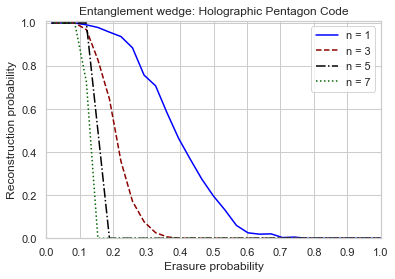

In [10]:
### Example 1 
onelayer_prob_2, onelayer_succes_2 = simulate(10000,create_hc_network,fivequbitcode,boundary_inclusion,greedy_algorithm_ent,1,1);
threelayer_prob_2, threelayer_succes_2 = simulate(10000,create_hc_network,fivequbitcode,boundary_inclusion,greedy_algorithm_ent,3,1);
fivelayer_prob_2, fivelayer_succes_2 = simulate(150,create_hc_network,fivequbitcode,boundary_inclusion,greedy_algorithm_ent,5,1);
sevenlayer_prob_2, sevenlayer_succes_2 = simulate(150,create_hc_network,fivequbitcode,boundary_inclusion,greedy_algorithm_ent,7,1);
drawt(onelayer_prob_2,onelayer_succes_2,30,"n = 1")
drawt(threelayer_prob_2,threelayer_succes_2,30,"n = 3")
drawt(fivelayer_prob_2,fivelayer_succes_2,30,"n = 5")
drawt(sevenlayer_prob_2,sevenlayer_succes_2,30,"n = 7")
plt.xlabel("Erasure probability");
plt.ylabel("Reconstruction probability");
plt.title("Entanglement wedge: Holographic Pentagon Code")
plt.legend()

half
half
half


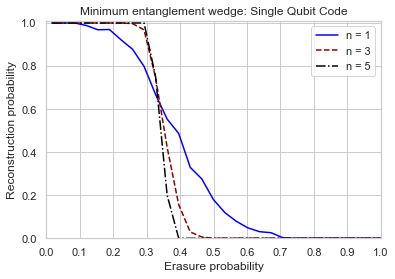

In [11]:
### Example 2
onelayer_prob_2, onelayer_succes_2 = simulate(10000,create_sq_network,fivequbitcode,boundary_inclusion,minimum_ent_wedge,1,1);
threelayer_prob_2, threelayer_succes_2 = simulate(10000,create_sq_network,fivequbitcode,boundary_inclusion,minimum_ent_wedge,3,1);
fivelayer_prob_2, fivelayer_succes_2 = simulate(100,create_sq_network,fivequbitcode,boundary_inclusion,minimum_ent_wedge,5,1);
drawt(onelayer_prob_2,onelayer_succes_2,30,"n = 1")
drawt(threelayer_prob_2,threelayer_succes_2,30,"n = 3")
drawt(fivelayer_prob_2,fivelayer_succes_2,30,"n = 5")
plt.xlabel("Erasure probability");
plt.ylabel("Reconstruction probability");
plt.title("Minimum entanglement wedge: Single Qubit Code")
plt.legend()

### 4. Stacked Tensor Networks
Excatly the same procedure of the last two chapters, only now bulk qubits are stackted on top of eachoter to form stacked tensor networks

In [14]:
### Stacked Holographic Pentagon Code
### Input: The tensor building block (code) and the length of the network from the center (layers) and stack height (stack)
### Output: List of stacked tensor networks made out of nested list of all the indivdual tensors, connected as a holographic pentagon network. 

def create_hc_network_stacked(code,layers,stack):
    network = []
    scramble_tensors = []
    for cur_stack in range(0,stack):
        bulk_q = 0
        tensorlist=[]
        ### create the first tensor
        node = tn.Node(code,name="Central tensor")
        tensorlist.append([node])
        #create first layer (it is different from the other ones)
        templist = []
        for j in range(0,6):
            if j !=5:
                templist.append(tn.Node(code,name= str(1) + "layer tensor , nr" + str(j)))
                tn.connect(tensorlist[0][0][j],templist[j][1],name = str(1) +','+ str(j)+ "connected to" + str(0)+ ','+str(0))
            else:
                tensorlist[0][0][j].name="Bulk qubit stack " + str(cur_stack) + ", nr"+str(bulk_q)
                #### connecting to previous stack bulk
                if cur_stack == 0:
                #### create RANDOM all_to_all scrambling circuit=> modeled with random tensor
                    temp_code = torch.rand((2,)*stack)
                    node = tn.Node(temp_code.numpy(),name="Scrambling tensor nr" + str(bulk_q))
                    tn.connect(node[0],tensorlist[0][0][j])
                    scramble_tensors.append(node)
                else:
                    tn.connect(scramble_tensors[bulk_q][cur_stack],tensorlist[0][0][j])
                bulk_q+=1
        tensorlist.append(templist)
        n=2
        ### create other layers
        while(n!=(layers+1)):
            templist = []
            total_count = 0
            for i in range(0,len(tensorlist[n-1])): # goes over tensors previous layers
                count = -1                                         ### to get the first edge to be bulk
                for edge in range(0,len(tensorlist[n-1][i].edges)):
                    if tensorlist[n-1][i][edge].name == "__unnamed_edge__":
                        count+=1
                        if count == 0:
                            tensorlist[n-1][i][edge].name = "Bulk qubit stack " + str(cur_stack) + ", nr"+str(bulk_q)
                            #### connecting to previous stack bulk
                            if cur_stack == 0:
                                 #### create RANDOM all_to_all scrambling circuit=> modeled with random tensor
                                temp_code = torch.rand((2,)*stack)
                                node = tn.Node(temp_code.numpy(),name="Scrambling tensor nr" + str(bulk_q))
                                tn.connect(node[0],tensorlist[n-1][i][edge])
                                scramble_tensors.append(node)
                            else:
                                tn.connect(scramble_tensors[bulk_q][cur_stack],tensorlist[n-1][i][edge])
                            bulk_q+=1
                        if count==1:
                            if i != 0:
                                tn.connect(tensorlist[n-1][i][edge],templist[-1][2],name = str(n) + ','+ str(total_count-1)+ "connected to" + str(n-1) +','+ str(i))
                            else: ##nothing yet in templist
                                total_count +=1
                                templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                                tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][2],name = str(n) + ','+ str(total_count-1)+ "connected to" + str(n-1) + ','+str(i))
                                tn.connect(tensorlist[n-1][-1][5],templist[total_count-1][1],name = str(n) +','+ str(total_count-1)+ "connected to" + str(n-1) +','+ str(len(tensorlist[n-1])-1))
                        if count>1:
                            total_count +=1
                            templist.append(tn.Node(code,name= str(n) + "layer tensor , nr" + str(total_count-1)))
                            tn.connect(tensorlist[n-1][i][edge],templist[total_count-1][1],name = str(n)+ ','+ str(total_count-1)+ "connected to" + str(n-1) +','+ str(i))   
            n = n+1
            tensorlist.append(templist)
        for i in range(0,len(tensorlist[n-1])): # goes over tensors previous layers
            count = -1                                         ### to get the first edge to be bulk
            for edge in range(0,len(tensorlist[n-1][i].edges)):
                if tensorlist[n-1][i][edge].name == "__unnamed_edge__":
                    count+=1
                    if count == 0:
                        tensorlist[n-1][i][edge].name = "Bulk qubit stack " + str(cur_stack) + ", nr"+str(bulk_q)
                        #### connecting to previous stack bulk
                        if cur_stack == 0:
                        #### create RANDOM all_to_all scrambling circuit=> modeled with random tensor
                            temp_code = torch.rand((2,)*stack)
                            node = tn.Node(temp_code.numpy(),name="Scrambling tensor nr" + str(bulk_q))
                            tn.connect(node[0],tensorlist[n-1][i][edge],name = "Bulk qubit stack " + str(cur_stack) + ", nr"+str(bulk_q))
                            scramble_tensors.append(node)
                        else:
                            tn.connect(scramble_tensors[bulk_q][cur_stack],tensorlist[n-1][i][edge],name="Bulk qubit stack " + str(cur_stack) + ", nr"+str(bulk_q))
                        bulk_q+=1
        network.append(tensorlist)
    network.insert(0,[scramble_tensors])
    return network


### Does the Monte-Carlo simulation of central qubit inclusion for a stacked pentagon network and entanglement wedge.
### Input: Iterations of simulation (n), function that creates the network,specific qubit code,boundary creationn algorithm, lenght of each tensor, if there is a bulk on the edge and stacks of network.
### Output: List of boundary ereasure probability used in each iteration (x) and List of succes rate (y) (1 if bulk qubit is included in wedge, 0 if not.)

def simulate_stacked(n,network_create,code,boundary_inc,algorithm,layer,bulk_on_edge,stack):
    x = []
    y = []
    for i in range(0,n):
        p = random.random()
        x.append(p)
        network = network_create(code,layer,stack)
        network = boundary_inc(network,p,bulk_on_edge) ## montecarlo simulations for earasure probability
        wedge = algorithm(network)
        succes = 0
        for tensors in wedge:
            if tensors.name == "Scrambling tensor nr0":
                succes = 1
        y.append(succes)
        if (i == n//2):
            print("half")
    return x,y

### Assign a random two-fold disconnected boundary to the edge of a stacked tensor network.
### Input: List of tensors (network), chance that bulk qubit is included in region 'A' (p), and bulk_on_edge (one if there is a bulk qubit on edge tensors, zero otherwise)
### Output: List of tensors where the boundary qubits are divided into two subregions 'A' and 'B'.

def boundary_inclusion_stacked(network,p,bulk_on_edge): ##bulk_on_edge one if there is bulk the edge => can't be part of boundary
    net  = network
    for stack in net[1:]:
        for tensors in stack[-1]: ### Important to remember that it is the edges that represent the qubits, not tensors
            for edge in tensors.edges:
                if edge.name == "__unnamed_edge__": ## dangling
                    if (random.random()<p):
                        edge.name = "A"
                    else:
                        edge.name = "B"
    return net

### Performs the greedy algorithm on all disconnected subregions across all stacks simultaneously. 
### Input: List of tensors with boundary assigned (network).
### Output: List of tensors included in the entanglment wedge.

def greedy_algorithm_stacked(network):
    ent_wedge = []      
    cont = 1 ##try at least once to get in the algorithm
    network =  list(chain.from_iterable(network))
    while(cont != 0):
        cont = 0
        for layers in list(reversed(network)): ## its important to come from outside to in
            for tensors in layers:
                if (tensors in ent_wedge):
                    pass
                else:## count how many edges are to tensors in causal wedge
                    legs_in_caus = 0
                    for edge in tensors.edges:
                        if edge.name[0] == "A":
                            legs_in_caus += 1
                    if legs_in_caus >= (len(tensors.edges)/2): ##if half or more are in wedge include
                        for  edge in tensors.edges:
                            if edge.name[0] =="A":
                                pass
                            else:
                                edge.name = "A" + edge.name
                        ent_wedge.append(tensors)
                        cont = 1 ## go another iteration over the while loop to check again
    return ent_wedge

### Plot generator
### Input: x and y from simulate, number of bins and label of graph
### Output: Plot 

lines = ["k-","k-","k--","k--","k-.","k-."]
color = ["blue","lightblue","darkred",(1.00,0.77,0.76),"black","gray"]
linecycler = cycle(lines)
colorcycler = cycle(color)
sns.set_theme(style="whitegrid")
def drawt(prob,succ,nbins,lab):
    recon_chance = []
    for i in np.linspace(0,1,nbins):
        succ_this_prob = 0
        count=0
        for x in range(0,len(prob)):
            if i-(1/nbins)<prob[x]<i:
                succ_this_prob+=succ[x]
                count+=1
        if count != 0:
            recon_chance.append(succ_this_prob/count)
        else:
             recon_chance.append(0)
    plt.plot(1-np.linspace(0,1,nbins)+(1/(2*nbins)),recon_chance,next(linecycler),color = next(colorcycler),label = lab)
    plt.xlim([0,1])
    plt.ylim([-0.0,1.01])
    plt.xticks(np.linspace(0,1,11))

half
half
half
half
half
half


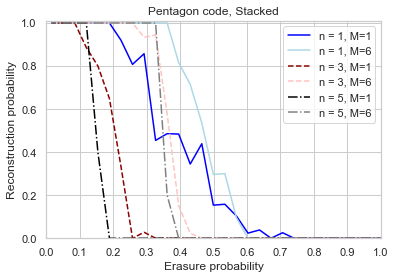

In [16]:
oneonestack_prob, oneonestack_succes = simulate_stacked(1000,create_hc_network_stacked,fivequbitcode,boundary_inclusion_stacked,greedy_algorithm_stacked,1,1,1);
sixonestack_prob, sixonestack_succes = simulate_stacked(1000,create_hc_network_stacked,fivequbitcode,boundary_inclusion_stacked,greedy_algorithm_stacked,1,1,6);
onethreestack_prob, onethreestack_succes = simulate_stacked(1000,create_hc_network_stacked,fivequbitcode,boundary_inclusion_stacked,greedy_algorithm_stacked,3,1,1);
sixthreestack_prob, sixthreestack_succes = simulate_stacked(1000,create_hc_network_stacked,fivequbitcode,boundary_inclusion_stacked,greedy_algorithm_stacked,3,1,6);
onefivestack_prob, onefivestack_succes = simulate_stacked(100,create_hc_network_stacked,fivequbitcode,boundary_inclusion_stacked,greedy_algorithm_stacked,5,1,1);
sixfivestack_prob, sixfivestack_succes = simulate_stacked(100,create_hc_network_stacked,fivequbitcode,boundary_inclusion_stacked,greedy_algorithm_stacked,5,1,6);
drawt(oneonestack_prob, oneonestack_succes,30,"n = 1, M=1")
drawt(sixonestack_prob, sixonestack_succes,30,"n = 1, M=6")
drawt(onethreestack_prob, onethreestack_succes,30,"n = 3, M=1")
drawt(sixthreestack_prob, sixthreestack_succes,30,"n = 3, M=6")
drawt(onefivestack_prob, onefivestack_succes,30,"n = 5, M=1")
drawt(sixfivestack_prob, sixfivestack_succes,30,"n = 5, M=6")
plt.xlabel("Erasure probability");
plt.ylabel("Reconstruction probability");
plt.title("Pentagon code, Stacked")
plt.legend()